# Image Segmentation on Forest Imagery

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [74]:
### importing required packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

## Data Preprocessing

In [75]:
base_dir = 'final inputs png/'
train_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')
# val_dir = os.path.join(base_dir, 'val')
# test_dir = os.path.join(base_dir, 'test')

In [76]:
# List dataset files
train_files = tf.data.Dataset.list_files(str(train_dir + '/*.png'), shuffle=True)
# val_files = tf.data.Dataset.list_files(str(val_dir + '/*/*.tiff'), shuffle=True)
# test_files = tf.data.Dataset.list_files(str(test_dir + '/*/*.tiff'), shuffle=True)

In [77]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  # Assuming RGB images
    img = tf.image.resize(img, [224, 224])  # Resize to desired dimensions
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img


In [78]:
def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.where(alpha_channel > 0, 1.0, 0.0)

    # Resize the binary mask to match the desired size (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [79]:
file = load_mask('final inputs png/mask/Peru_1067_2017-08-23T15_06_18Z_0011_cropped_7.png')

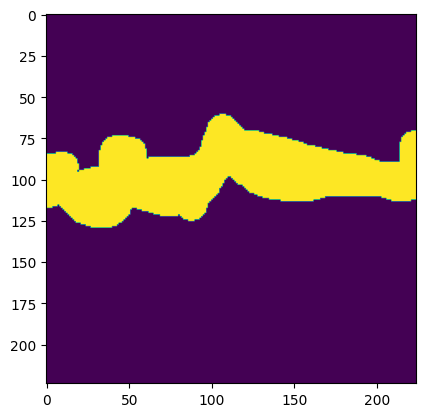

In [80]:
import matplotlib.pyplot as plt

plt.imshow(file)

In [81]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [82]:
# Get list of all images and masks (assuming filenames match)
image_paths = sorted([os.path.join(train_dir, fname) for fname in os.listdir(train_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [83]:
# Create a TensorFlow Dataset from the file paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
print(dataset.element_spec)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [84]:
# # Shuffle, batch, and prefetch for efficient training
# dataset = dataset.shuffle(buffer_size=100).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

### Visualizing the Images

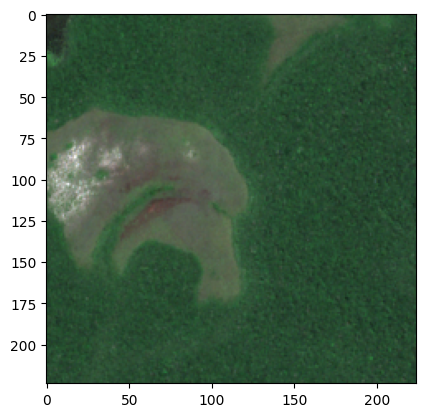

In [85]:
image, mask = next(iter(dataset))
_ = plt.imshow(image)
#_ = plt.title(get_label_name(label))

### Preparing data for Training

In [86]:
# from tensorflow.keras import layers

# # Define the data augmentation pipeline
# data_augmentation = tf.keras.Sequential([
#     #layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
# ])

In [87]:
# def prepare_for_training(ds, batch_size=32):
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.repeat()
#     ds = ds.batch(batch_size)
#     # add augmentation here
#      # Add data augmentation
#     # ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#     #             num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
#     ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#     return ds

In [88]:
# # Prepare for training
# train_dataset = prepare_for_training(dataset)
# # val_dataset = prepare_for_training(val_dataset)
# # test_dataset = prepare_for_training(test_dataset, batch_size=1)

## Modeling

In [89]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [90]:
# TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [91]:
train_batches = (
    dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# test_batches = test_images.batch(BATCH_SIZE)

In [92]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

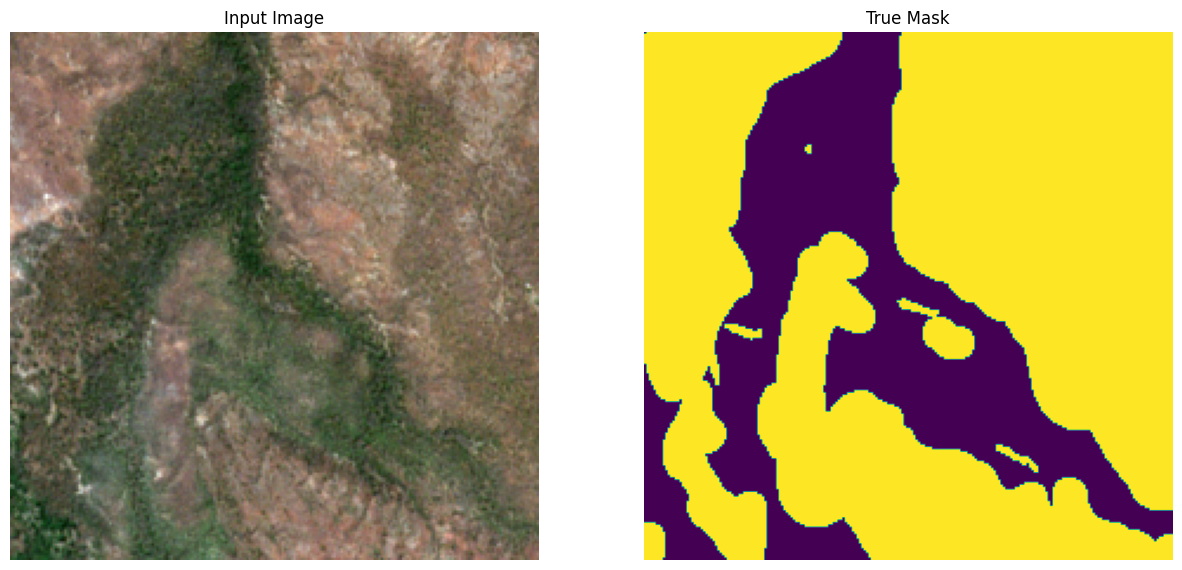

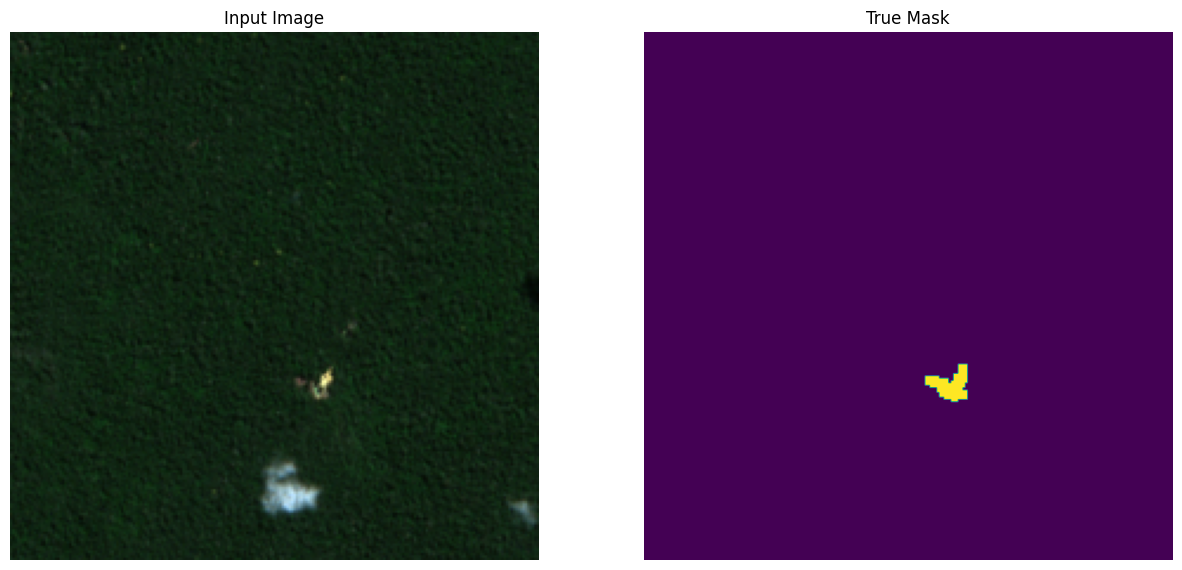

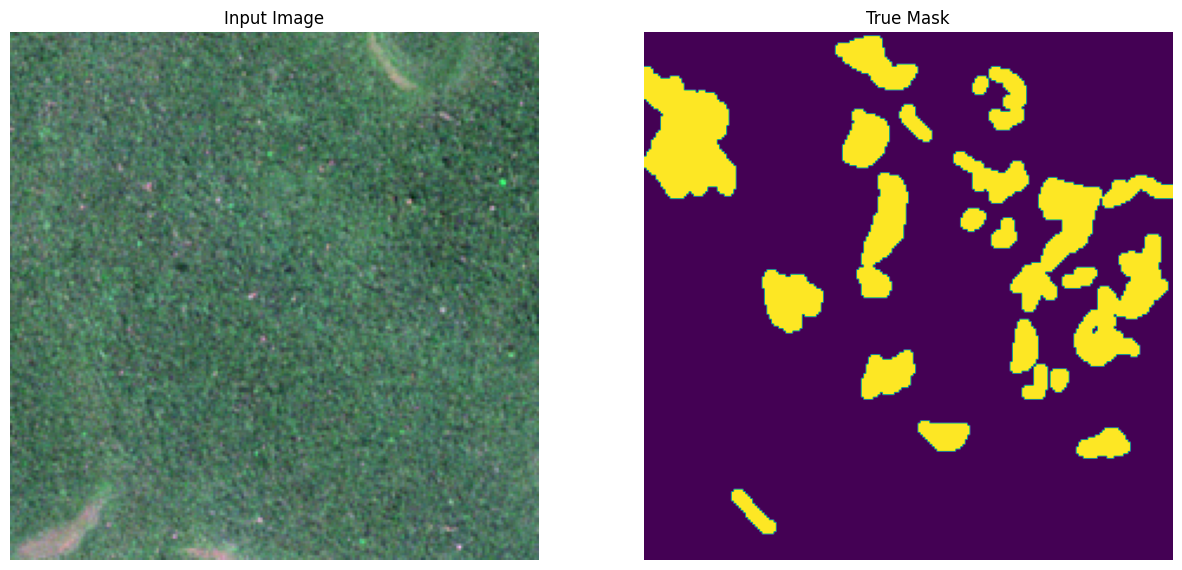

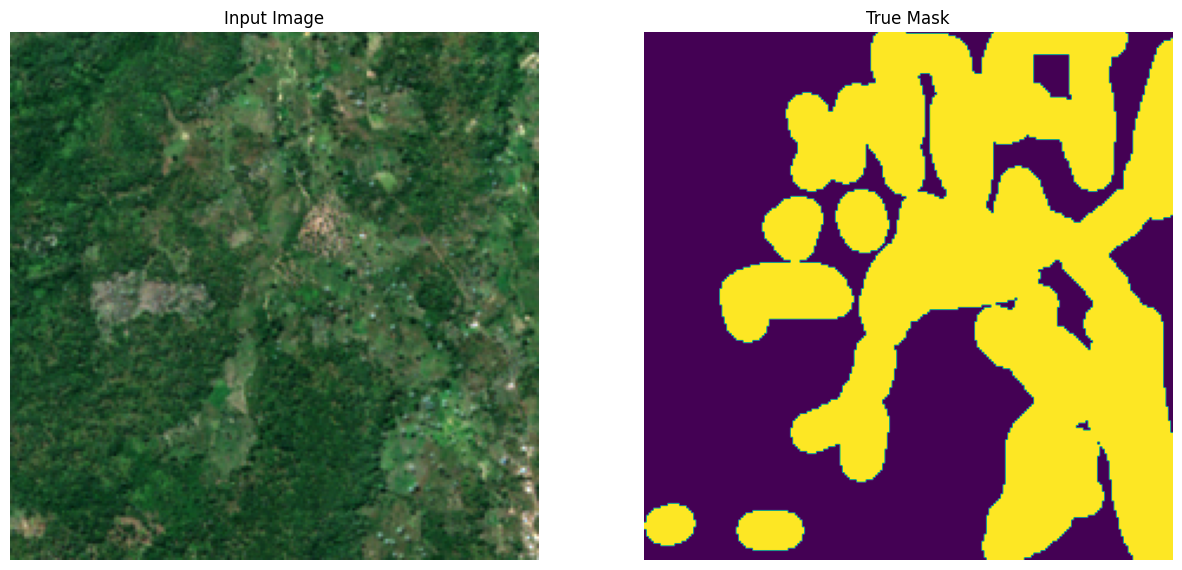

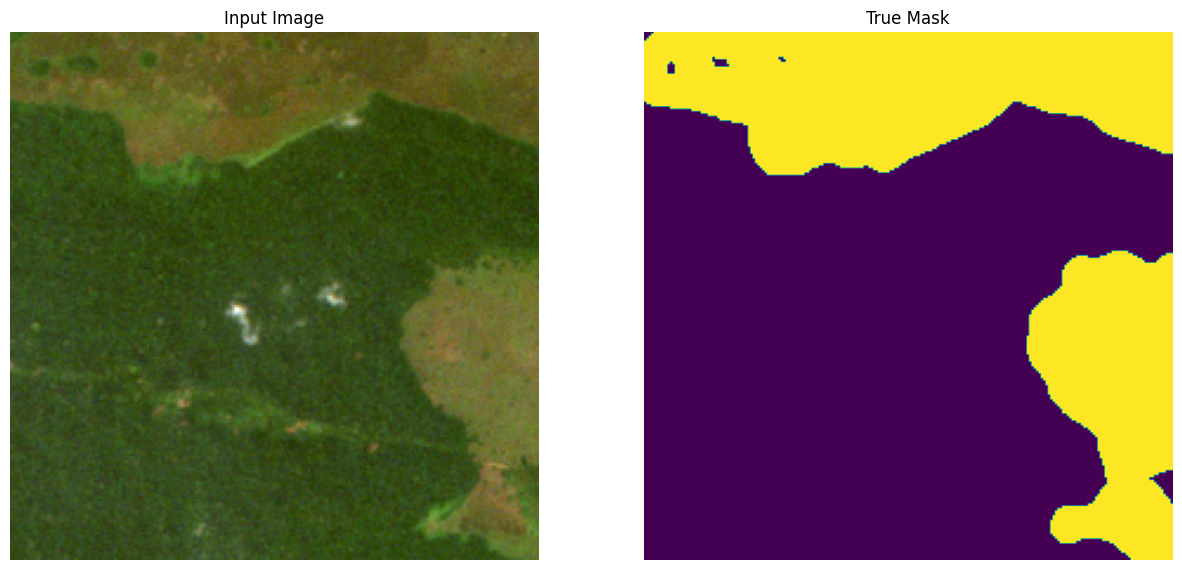

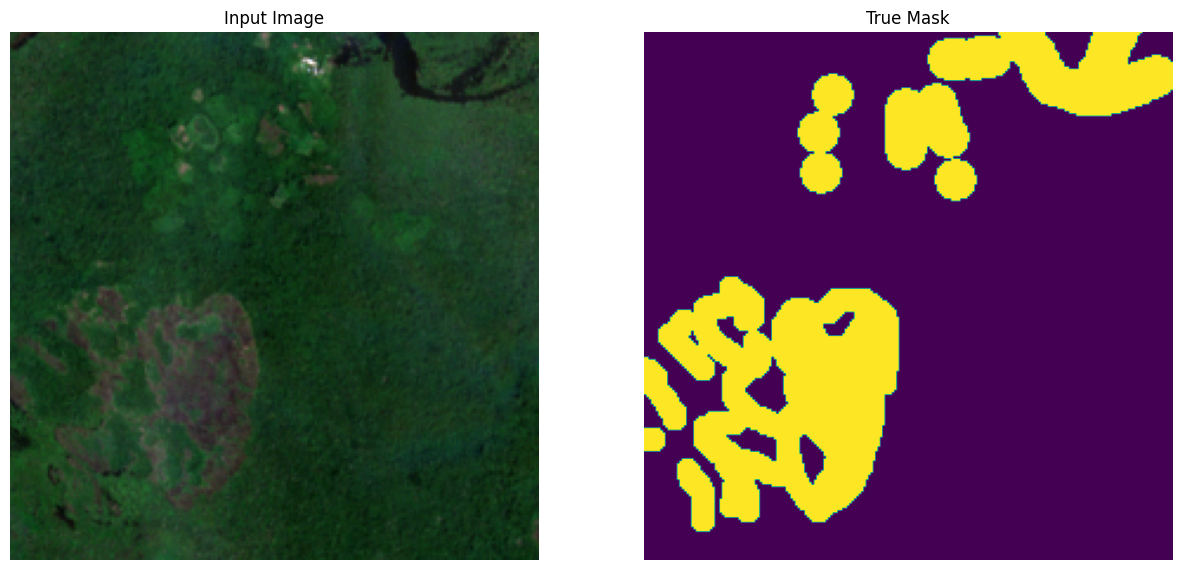

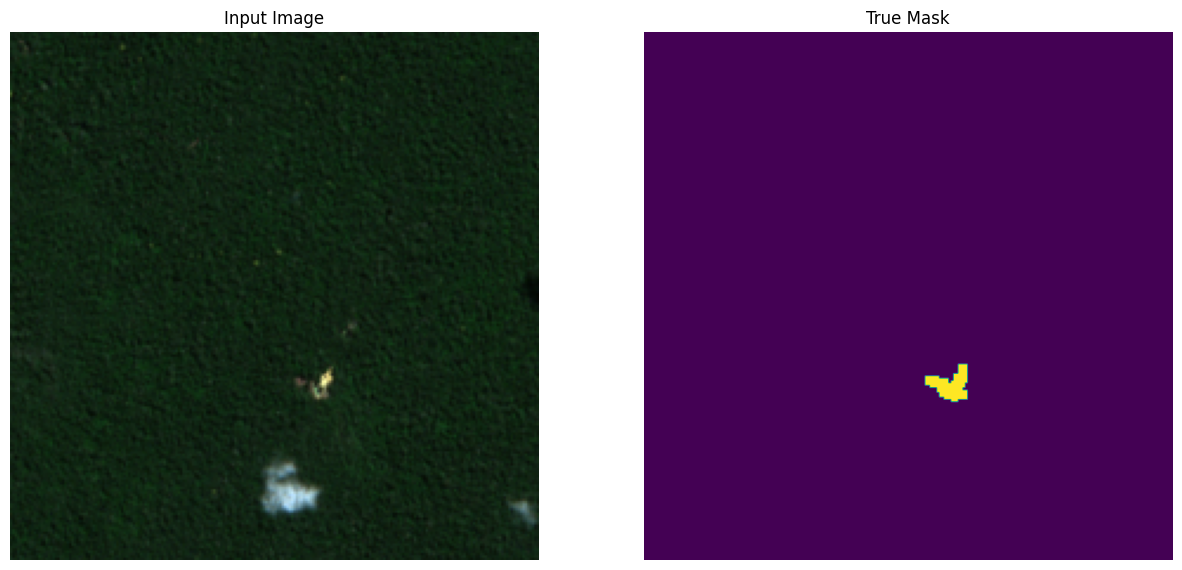

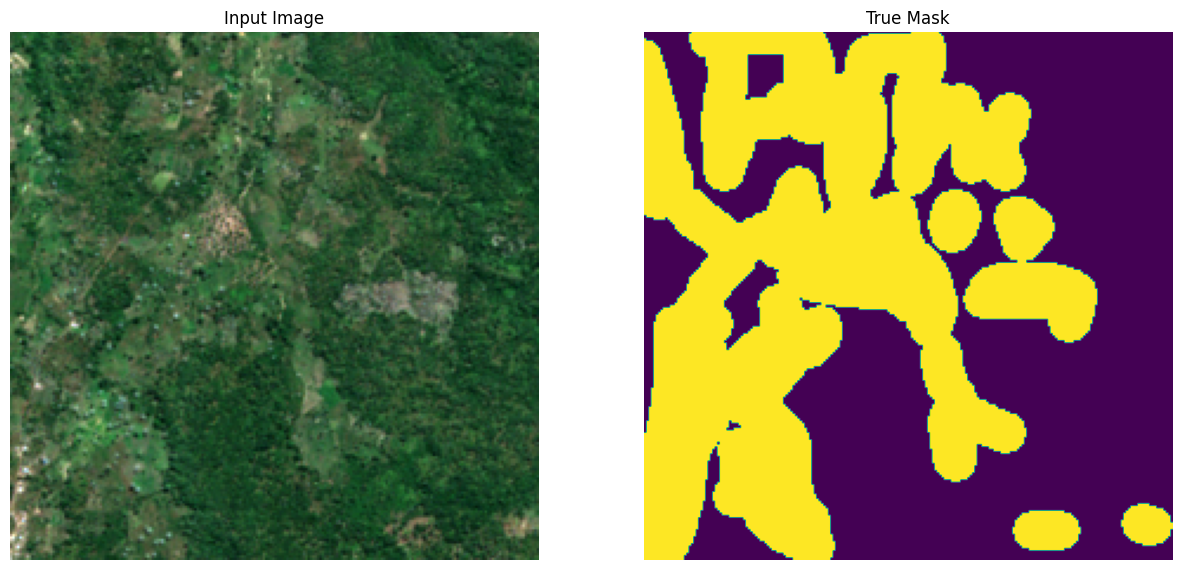

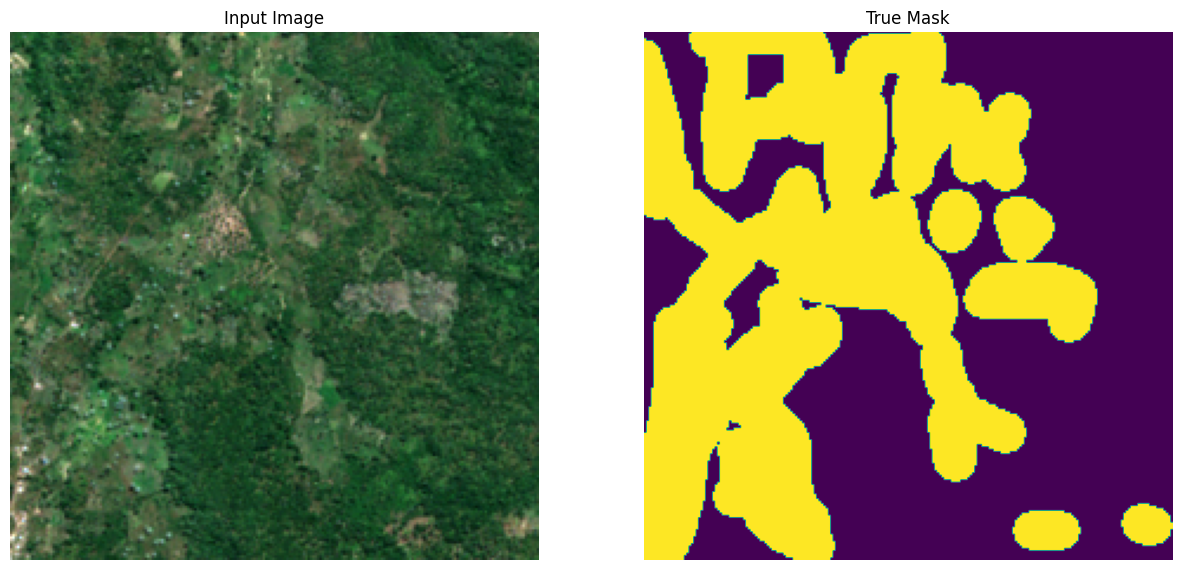

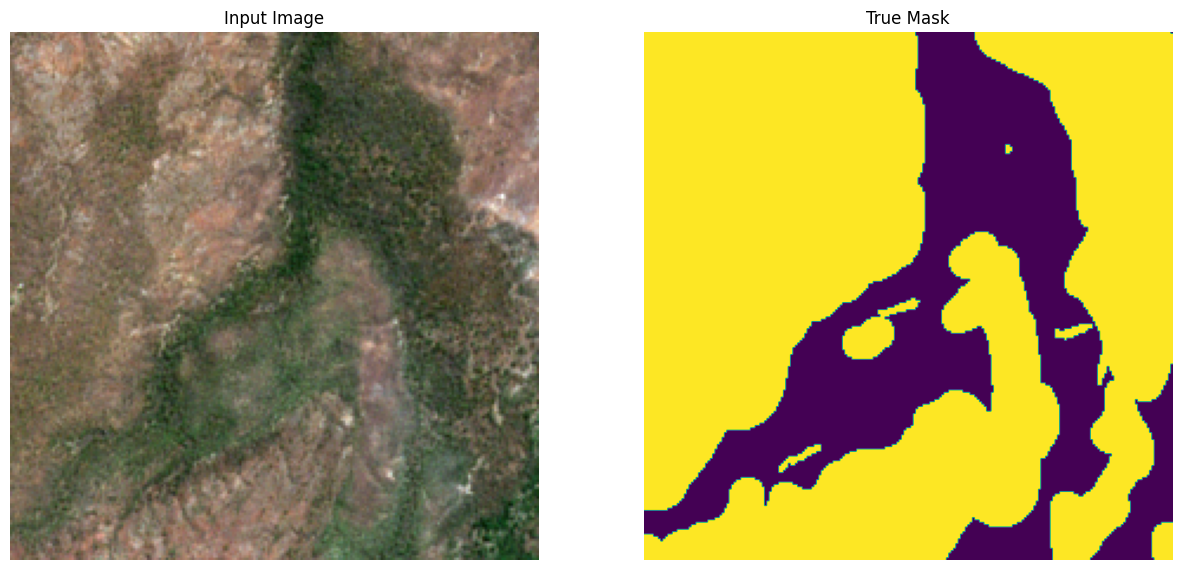

In [93]:
for images, masks in train_batches.take(10):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [94]:
from tensorflow_examples.models.pix2pix import pix2pix
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [46]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [95]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [96]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_14       │ [(None, 112, 112, │  1,841,984 │ input_layer_15[0… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 14, 14,    │  1,476,608 │ functional_14[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 14, 14,    │          0 │ sequential_4[1][… │
│ (Concatenate)       │ 1088)             │            │ functional_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 28, 28,    │  2,507,776 │ concatenate_8[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 28, 28,    │          0 │ sequential_5[1][… │
│ (Concatenate)       │ 448)              │            │ functional_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 56, 56,    │    516,608 │ concatenate_9[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 56, 56,    │          0 │ sequential_6[1][… │
│ (Concatenate)       │ 272)              │            │ functional_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 112, 112,  │    156,928 │ concatenate_10[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 112, 112,  │          0 │ sequential_7[1][… │
│ (Concatenate)       │ 160)              │            │ functional_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 224, 224,  │      1,441 │ concatenate_11[0… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,501,345 (24.80 MB)

 Trainable params: 4,657,441 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [98]:
EPOCHS = 5
VAL_SUBSPLITS = 5
steps_per_epoch=len(train_files) // 32
history=model.fit(train_batches,
                  steps_per_epoch=steps_per_epoch,
                  epochs=EPOCHS)

model.summary

Epoch 1/5
     63/Unknown 50s 752ms/step - accuracy: 0.5875 - loss: 2.0715

KeyboardInterrupt: 